In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.3.0+cu121


In [2]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 43.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
# packages
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import torch
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F
from sklearn.manifold import TSNE
import seaborn as sns

In [4]:
# dataset
dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())


Processing...
Done!


In [5]:
print(f'Dataset: {dataset}:')
print(f'# graphs: {len(dataset)}')
print(f'# features: {dataset.num_features}')
print(f'# classes: {dataset.num_classes}')

Dataset: PubMed():
# graphs: 1
# features: 500
# classes: 3


In [6]:
data = dataset[0]
print(data)

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


In [8]:
# train the model
class GCN(torch.nn.Module):
    def __init__(self, num_hidden, num_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, num_hidden)
        self.conv2 = GCNConv(num_hidden, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.2)
        x = self.conv2(x, edge_index)
        return x

class GAT(torch.nn.Module):
    def __init__(self, num_hidden, num_features, num_classes, heads = 8):
        super().__init__()
        self.conv1 = GATConv(num_features, num_hidden, heads)
        self.conv2 = GATConv(heads*num_hidden, num_classes, heads)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.3)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3)
        x = self.conv2(x, edge_index)
        return x

Epoch: 0, Loss: 3.178367853164673
Epoch: 1, Loss: 3.1694211959838867
Epoch: 2, Loss: 3.1605803966522217
Epoch: 3, Loss: 3.1515729427337646
Epoch: 4, Loss: 3.1414260864257812
Epoch: 5, Loss: 3.1324169635772705
Epoch: 6, Loss: 3.1221814155578613
Epoch: 7, Loss: 3.1117982864379883
Epoch: 8, Loss: 3.101289987564087
Epoch: 9, Loss: 3.0904176235198975
Epoch: 10, Loss: 3.078387498855591
Epoch: 11, Loss: 3.0655641555786133
Epoch: 12, Loss: 3.0529749393463135
Epoch: 13, Loss: 3.0420291423797607
Epoch: 14, Loss: 3.027291774749756
Epoch: 15, Loss: 3.013195514678955
Epoch: 16, Loss: 2.9958407878875732
Epoch: 17, Loss: 2.980935573577881
Epoch: 18, Loss: 2.9654650688171387
Epoch: 19, Loss: 2.9466023445129395
Epoch: 20, Loss: 2.9327552318573
Epoch: 21, Loss: 2.915269136428833
Epoch: 22, Loss: 2.8962972164154053
Epoch: 23, Loss: 2.8766913414001465
Epoch: 24, Loss: 2.859036445617676
Epoch: 25, Loss: 2.831977128982544
Epoch: 26, Loss: 2.8108201026916504
Epoch: 27, Loss: 2.7897493839263916
Epoch: 28, Los

<Axes: >

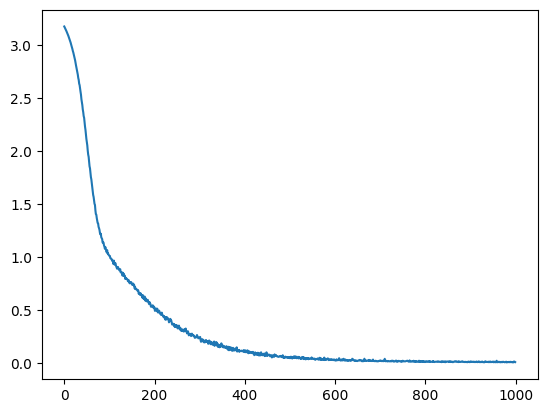

In [9]:
model = GAT(num_hidden=16, num_features=dataset.num_features, num_classes=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

# model training
loss_lst = []
model.train()
for epoch in range(1000):
    optimizer.zero_grad()
    y_pred = model(data.x, data.edge_index)
    y_true = data.y
    loss = criterion(y_pred[data.train_mask], y_true[data.train_mask])
    loss_lst.append(loss.item())
    loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch}, Loss: {loss}')

# Train Loss
sns.lineplot(x=list(range(len(loss_lst))), y=loss_lst)

In [10]:
# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(data.x, data.edge_index)
    y_pred_cls = y_pred.argmax(dim=1)
    correct_pred = y_pred_cls[data.test_mask] == data.y[data.test_mask]
    test_acc = int(correct_pred.sum()) / int(data.test_mask.sum())
print(f'Test Accuracy: {test_acc}')

Test Accuracy: 0.76


<Axes: >

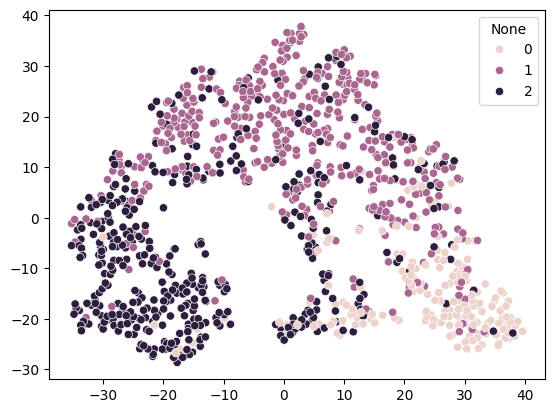

In [11]:
# Visualise result
z = TSNE(n_components=2).fit_transform(y_pred[data.test_mask].detach().cpu().numpy())
sns.scatterplot(x=z[:, 0], y=z[:, 1], hue=data.y[data.test_mask])